# 価値反復法による強化学習の例
価値反復法に基づく強化学習アルゴリズムとして
* Sarsa
* Q-learning

の2つの実装例を紹介します。

In [1]:
# 必要なmoduleのimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from environment import EnvSensor
from reward import Reward
from policy import ValueIteration
from utils import stop_episode, plot_demo

## A. ValueIteration classの紹介
`policy` moduleには、SarsaまたはQ-learningによる決定方策の価値反復法を`ValueIteration` classとして実装しています。このclassの使い方を紹介しましょう。

In [2]:
# instanceのbuild : Sarsaの場合
pol = ValueIteration(method = "Sarsa")

いずれもQ tableを価値反復法によって更新します。Q tableは各状態においてある行動を行った結果、その後の累積割引報酬がいくらになると期待できるかを表すための表です。最初は、何らかの初期値を振っておき、更新するなかで真の値に近づけていくことを目指します。また、Q tableが収束したら各状態で最も価値の高い行動をとるような決定方策を解とします。

`ValueIteration` classではQ tableの値を`Q_table` 変数で参照することが出来ます。

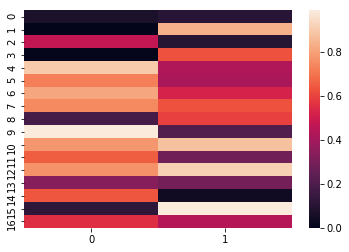

In [3]:
sns.heatmap(pol.Q_table)
plt.show()

`get_action(state)` methodでは、各状態において現状のQ tableから最も価値の高い行動を返します。なお、`epsilon`引数を用いて探索率を指定し、`ε-greedy`方策を用いることができます。

**演習** : 以下の結果を`epsilon`に指定した値から説明してみてください。

In [4]:
actions = []
for i in range(100):
    actions.append(pol.get_action(state = 130, epsilon = 0.2))
np.unique(actions, return_counts = True)

(array([0, 1], dtype=int64), array([ 9, 91], dtype=int64))

## B. Sarsa algorithmの例
さて、Sarsa algorithmによってQ tableを学習してみましょう。
* 学習するepisode数 : 5000回
* 1 episodeあたりのaction数 : 120回

とします。

In [5]:
n_episode = 5000
n_actions = 120
env = EnvSensor()
rew = Reward()
pol = ValueIteration(method = "Sarsa")
reward_each_episode = []
cumulative_rewards = []

Sarsa algorithmの学習は、step単位で実行されます。`fit(reward, gamma, learning_rate, end_of_episode, val)` methodでは、
* reward : 直前のactionに対する報酬を代入する。
* gamma : 最適化したい累積割引報酬の割引率（0<gamma<1）
* learning_rate : 各episodeでの学習率
* end_of_episode : 1 episodeが終了したかどうか。
* val : 未知episodeに対する累積報酬の計算（計算量が重くなるため普段はFalseでよい。）

を与えることで、Q tableの学習を計算します。**episode数（n_episode）**が少ない場合、Q tableを十分に精度よく推定することができないので注意してください。

In [6]:
for i in tqdm(range(n_episode)):    # s[t]=state, a[t]=action, s[t+1]=state_, a[t+1]=action_
    state = env.reset()
    action = pol.get_action(state = state, epsilon = 0.2)
    for j in range(2, n_actions + 1):
        state_ = env.get_state(action = action)
        reward = rew.get_reward(state = state_)
        action_ = pol.get_action(state = state_, epsilon = 0.2)
        if stop_episode(time = j) == 0:
            pol.fit(reward = reward, gamma = 0.9,
                    state = state, action = action, state_ = state_, action_ = action_,
                    learning_rate = 1/(0.01*i+1), end_of_episode = False, val = True)
            # rewardのログ、state_, action_を保存する。
            reward_each_episode.append(reward)
            state, action = state_, action_
        elif stop_episode(time = j) == 1:
            #print("episode " + str(i) + " : " + str(j) + \
            #      " actions and final reward " + str(reward))
            pol.fit(reward = reward, gamma = 0.9, 
                    state = state, action = action,
                    learning_rate = 1/(0.01*i+1), end_of_episode = True, val = True)
            cumulative_rewards.append(np.sum(reward_each_episode))    # episodeの累積報酬のログを取る。
            reward_each_episode = []    # rewardのログを初期化
            break
print("End of all episodes")


End of all episodes


学習の結果を以下に可視化しました。特に右のグラフを見ると、stepが進むごとにgradientが徐々に小さくなってきていることが見て取れるでしょう。これは学習が収束しつつあることを意味しています。

**演習** : 左のグラフは、赤線が学習中の累積割引報酬、青線が検証時の累積割引報酬です。学習時には`ε-greedy`方策、検証時にはその時点で得られている決定方策で累積割引報酬を計算しています。このことを元に、なぜ赤線には累積割引報酬が下がるepisodeがしばしば存在する関わらわず、青線では累積割引報酬がある程度一定の値を推移するのかを考えてみてください。

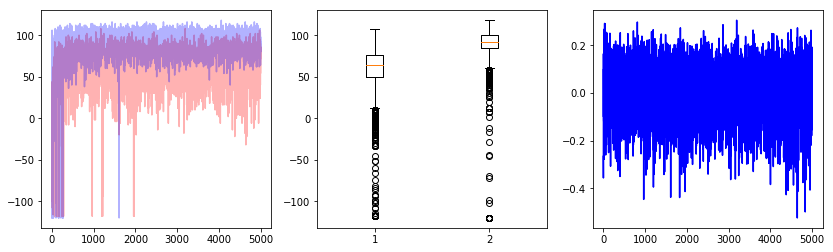

In [7]:
episode_index = np.arange(n_episode)
plt.figure(figsize = (14, 4))
plt.subplot(1, 3, 1)
plt.plot(episode_index, cumulative_rewards, color = "red", alpha = 0.3)
plt.plot(episode_index, pol.val_cumulative_rewards, color = "blue", alpha = 0.3)
plt.subplot(1, 3, 2)
plt.boxplot([cumulative_rewards, pol.val_cumulative_rewards])
plt.subplot(1, 3, 3)
plt.plot(episode_index, pol.mean_temporal_difference_errors, color = "blue")
plt.show()

得られた決定方策によって、新しい環境で累積報酬・温度調整の成功回数をどれだけ得ることが出来るのか調べてみましょう。以下の結果を見てください。

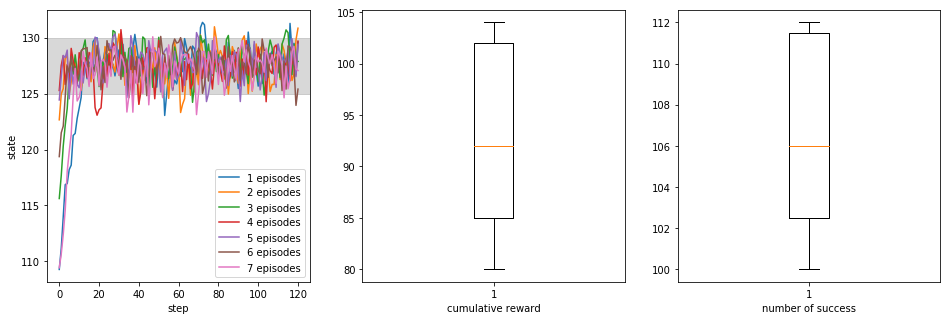

In [8]:
plot_demo(env = env, pol = pol, n_episodes = 7, steps_per_episode = 120)

学習後のQ tableも見てみましょう。上手く学習できていることが分かります。また、`fit_counter` 変数を用いてQ tableの各セルが学習された回数を調べることが出来ます。これを可視化したものが右のグラフですが、どのセルもある程度多く更新されたことが見て取れます。

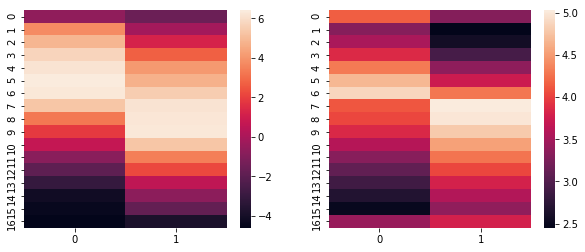

In [9]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(pol.Q_table)
plt.subplot(1, 2, 2)
sns.heatmap(np.log10(pol.fit_counter+1))
plt.show()

## C. Q-learningの例
Sarsa algorithmと同様のことをQ-learningでも行ってみましょう。

In [10]:
n_episode = 5000
n_actions = 120
env = EnvSensor()
rew = Reward()
pol = ValueIteration(method = "Q_learning")
reward_each_episode = []
cumulative_rewards = []

In [11]:
for i in tqdm(range(n_episode)):    # s[t]=state, a[t]=action, s[t+1]=state_, a[t+1]=action_
    state = env.reset()
    action = pol.get_action(state = state, epsilon = 0.2)
    for j in range(2, n_actions + 1):
        state_ = env.get_state(action = action)
        reward = rew.get_reward(state = state_)
        if stop_episode(time = j) == 0:
            pol.fit(reward = reward, gamma = 0.9,
                    state = state, action = action, state_ = state_,
                    learning_rate = 1/(0.01*i+1), end_of_episode = False, val = True)
            action_ = pol.get_action(state = state_, epsilon = 0.2)
            # rewardのログ、state_, action_を保存する。
            reward_each_episode.append(reward)
            state, action = state_, action_
        elif stop_episode(time = j) == 1:
            #print("episode " + str(i) + " : " + str(j) + \
            #      " actions and final reward " + str(reward))
            pol.fit(reward = reward, gamma = 0.9, 
                    state = state, action = action,
                    learning_rate = 1/(0.01*i+1), end_of_episode = True, val = True)
            cumulative_rewards.append(np.sum(reward_each_episode))    # episodeの累積報酬のログを取る。
            reward_each_episode = []    # rewardのログを初期化
            break
print("End of all episodes")


End of all episodes


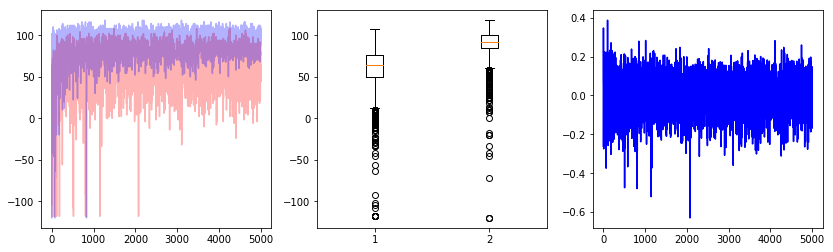

In [12]:
episode_index = np.arange(n_episode)
plt.figure(figsize = (14, 4))
plt.subplot(1, 3, 1)
plt.plot(episode_index, cumulative_rewards, color = "red", alpha = 0.3)
plt.plot(episode_index, pol.val_cumulative_rewards, color = "blue", alpha = 0.3)
plt.subplot(1, 3, 2)
plt.boxplot([cumulative_rewards, pol.val_cumulative_rewards])
plt.subplot(1, 3, 3)
plt.plot(episode_index, pol.mean_temporal_difference_errors, color = "blue")
plt.show()

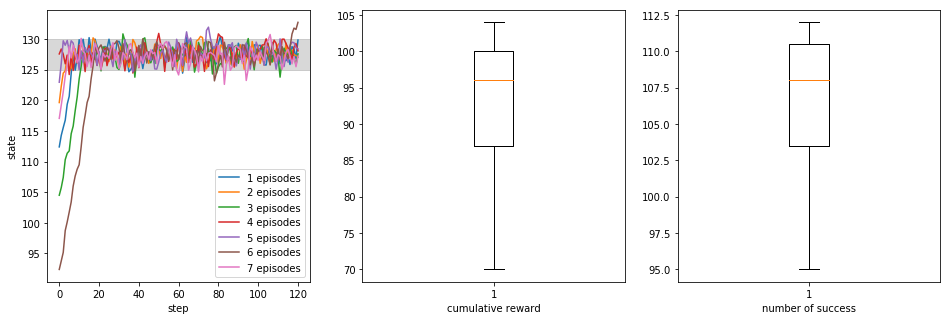

In [13]:
plot_demo(env = env, pol = pol, n_episodes = 7, steps_per_episode = 120)

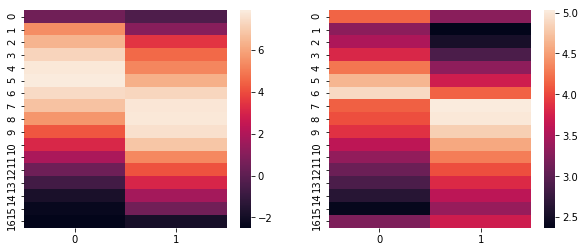

In [14]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(pol.Q_table)
plt.subplot(1, 2, 2)
sns.heatmap(np.log10(pol.fit_counter+1))
plt.show()

## D. SarsaとQ-learningの比較
Q-learningは、Robbins-Monro条件のもとで最適方策に確率1で収束することが知られています。Robbins-Monro条件とは、episode $t$における学習率$\eta_t$が
\begin{eqnarray*}
\sum_{t=1}^{\infty}\eta_t = \infty &, & \sum_{t=1}^{\infty}\eta^2_t < \infty\\
\end{eqnarray*}
を満たすことをいいます。スクリプトで学習率（learning_rate）を1.0/(episode+1)と置いたのも、この条件を満たすための設定です。なお、実際には学習率を定数で固定するケースもあります。

一方でSarsaは、εを0でない定数に固定した場合、最適方策よりもよりstableに報酬を得られるような方策があれば、そちらを学習する傾向があります。

**演習** : Sarsaの訓練時の累積割引報酬とQ-learningの訓練時の累積割引報酬を比較したとき、Q-learningのほうがSarsaに比べて高い値・低い値を取りやすいことを何度か実験することで確認してみてください。また、それらの結果をSarsaの性質から説明してください。

なお、SARSAもまたεを1/episodeのスピードで0に収束させることで、十分なepisode数の学習を経れば最適方策に確率1で収束することが知られています。